This page includes python code that was used to generate these figures, where again we saw just how troublesome the limitations of existing platforms in handling projections intelligently can be. Some of the code is a bit overwhelming, so it is hidden by default, but you can see it by clicking into the **Code &#9658;** blocks. 

In [187]:
#| code-fold: true
import math
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import shapely.geometry as geom

%matplotlib inline 
import matplotlib.pyplot as pyplot

## The base data
This is dataset 11 from the site linked [here](links-6.qmd#footnote-6) and shows the numbers of offices of 100 major firms that exist in a collection of 315 cities. The network we build is based on shared offices of firms, i.e. if two cities both have offices of the same firm, then they are linked.

In [188]:
wcn = pd.read_csv("da11-1.csv", index_col = 0)
wcn.head(5)

,Ernst & Young,Arthur Andersen,MSI,IGAF,AGN,BDO,Grant Thornton,Horwath,KPMG,Summit & Baker,...,Mercer,Boston,Deloitte,BoozeA&M,A.T. Kearney,McKinsey,Bain,Compass,Andersen Consulting,Gemini
name,,,,,,,,,,,,,,,,,,,,,
ABERDEEN,2,0,0,0,0,0,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
ABIJAN,3,0,0,0,0,0,0,0,2,0,...,0,0,2,0,0,0,0,0,0,0
ABU DHABI,2,2,0,0,2,0,0,2,2,0,...,0,0,2,2,0,0,0,0,2,0
ACCRA,0,0,0,0,0,0,2,0,2,0,...,0,0,2,0,0,0,0,0,0,0
ADDIS ABABA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Making the data into a network
The two function in the code block below enable filtering the raw data to only retain cities that have some number or more offices of each firm, and then by matrix multiplication to convert this table into the adjacency matrix of a graph.

In [189]:
#| code-fold: true

def cut_table_at(table, x):
    tbl = table.copy()
    tbl[tbl[:] < x] = 0
    tbl[tbl[:] > 0] = 1
    return tbl[list(tbl.sum(axis=1) > 0)]

def make_network_from_incidence_table(tbl):
    incidence_matrix = np.array(tbl)
    adj_matrix = incidence_matrix.dot(incidence_matrix.transpose())
    np.fill_diagonal(adj_matrix, 0)
    G = nx.Graph(adj_matrix)
    return nx.relabel_nodes(G, dict(zip(G.nodes(), list(tbl.index))))

### The geography
Below, we use the previous functions to form the graph, and then add longitude-latitude coordinates for each city to the nodes.

In [190]:
Gnx = make_network_from_incidence_table(cut_table_at(wcn, 4))

wcn_ll = pd.read_csv("wcn-cities-ll.csv", index_col=0)

for name in Gnx.nodes():
    lon = wcn_ll.loc[name]["LONGITUDE"]
    lat = wcn_ll.loc[name]["LATITUDE"]
    Gnx.nodes[name]["lat"] = lat
    Gnx.nodes[name]["lon"] = lon

At this point, we can make up a naïve map (i.e. Figure 6.5a), simply connecting the end point coordinates of each edge in the graph with straight lines.

<Axes: >

<Figure size 3600x1800 with 0 Axes>

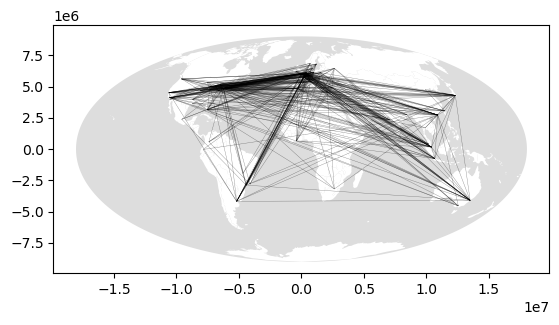

In [191]:
city_to_city = []
for e in Gnx.edges():
    p1 = geom.Point(Gnx.nodes[e[0]]["lon"], Gnx.nodes[e[0]]["lat"])
    p2 = geom.Point(Gnx.nodes[e[1]]["lon"], Gnx.nodes[e[1]]["lat"])
    city_to_city.append(geom.LineString([p1, p2]))

# make up the naive links linestring dataset
city_to_city_gdf = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(city_to_city))
city_to_city_gdf.crs = "+proj=longlat"

moll = "+proj=moll"
# make up a 'globe' polygon for the background to the world maps
globe = geom.Polygon(
  [geom.Point(-180, y) for y in [_ / 10 for _ in range(-900, 901)]] + \
  [geom.Point( 180, y) for y in [_ / 10 for _ in range(900, -901, -1)]])
globe_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries([globe]))
globe_gdf.crs = "+proj=longlat"

# get countries data
countries = gpd.read_file("ne-world.gpkg")

# and make up a map
fig = pyplot.figure(figsize=(12, 6), dpi = 300)
ax = globe_gdf.to_crs(moll).plot(fc = "#dddddd")
countries.to_crs(moll).plot(ax = ax, fc = "w", linewidth = 0)
city_to_city_gdf.to_crs(moll).plot(
    ax = ax, color = "k", alpha = 0.5, linewidth = 0.25)

### The world is not flat
That map is not very useful, although avoiding making this kind of nonsense map is surprisingly difficult&mdash;another consequence of the limitations of how projections are handled in contemporary platforms. Things get complicated though... you have been warned...

So, we need several functions. First, the great circle distance beween two longitude-latitude points.

In [192]:
# Uses the Haversine formulae, see
# https://en.wikipedia.org/wiki/Haversine_formula
def get_great_circle_distance(p1: geom.Point, p2: geom.Point,
                                    R: float = 6378.137):
    lon0 = math.radians(p1.x)
    lat0 = math.radians(p1.y)
    lon1 = math.radians(p2.x)
    lat1 = math.radians(p2.y)
    dlon = lon1 - lon0
    dlat = lat1 - lat0
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + \
        math.cos(lat0) * math.cos(lat1) * \
        math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return (R * c)

Next, a function to return a great circle line string between two points.

In [193]:
def interpolate_between(z1: float, z2: float, steps: int):
    fractions = [(1 + x) / steps for x in range(steps - 1)]
    return [z1] + [(z2 - z1) * f for f in fractions] + [z2]

def get_geodesic(p1: geom.Point, p2: geom.Point, step_length: int = 10):
    dist = get_great_circle_distance(p1, p2)
    # determine number of steps
    n_steps = math.ceil(dist / step_length) 
    # reproject in a space where great circles are straight lines
    gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries([p1, p2]))
    gdf.crs = "+proj=longlat"
    gdf = gdf.to_crs(f"+proj=aeqd +lon_0={p1.x} +lat_0={p1.y}")
    np1x, np1y = gdf.geometry[0].x, gdf.geometry[0].y
    np2x, np2y = gdf.geometry[1].x, gdf.geometry[1].y
    xs = interpolate_between(np1x, np2x, n_steps)
    ys = interpolate_between(np1y, np2y, n_steps)
    ngdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(
        geom.Point(x, y) for x, y in zip(xs, ys)))
    ngdf.crs = f"+proj=aeqd +lon_0={p1.x} +lat_0={p1.y}"
    points = list(ngdf.to_crs("+proj=longlat").geometry)
    return geom.LineString((p.x, p.y) for p in points) 

Next, a function that takes geodesic and breaks itat any point where there is large apparent jump between consecutive points. Here we use the naïve distance measurement based on the coordinates. This will mean the line is broken at the antimeridian.

In [194]:
def split_at_jumps(geodesic: geom.LineString):
    points = geodesic.coords
    # make into a series of LineStrings
    segments = [geom.LineString([p1, p2]) 
                   for p1, p2 in zip(points[:-1], points[1:])]
    lengths = [ls.length for ls in segments]
    intersections = [l > 1 for l in lengths]
    if True in intersections:
        idx = intersections.index(True)
        coords1 = points[:idx]
        coords2 = points[idx+1:]
        if len(coords1) > 1 and len(coords2) > 1:
            return geom.MultiLineString([coords1, coords2])
        elif len(coords1) == 1 and len(coords2) == 1:
            return geom.MultiPoint(points)
        else:
            if len(coords1) > len(coords2):
                return geom.LineString(coords1)
            else:
                return geom.LineString(coords2)
    else:
        return geom.LineString(points)

### Code to make dense geodesics

In [195]:
geodesics = [] # list of LineStrings along the geodesic
cut_geodesics = [] # list of the geodesics cut at the dateline

# iterate over the edges
for e in Gnx.edges():
    p1 = geom.Point(Gnx.nodes[e[0]]["lon"], Gnx.nodes[e[0]]["lat"])
    p2 = geom.Point(Gnx.nodes[e[1]]["lon"], Gnx.nodes[e[1]]["lat"])

    g = get_geodesic(p1, p2)
    geodesics.append(g)
    cut_geodesics.append(split_at_jumps(g))

In [196]:
geodesics_gdf = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(geodesics))
geodesics_gdf.crs = "+proj=longlat"

geodesics_cut_gdf = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(cut_geodesics))
geodesics_cut_gdf.crs = "+proj=longlat"

## Mollweide fail maps
More maps that don't quite work. The first of these doesn't break the great circle links at the anti-meridian (dateline) so we get 'parallels' from one side of the map to the other when one crosses the anti-meridian. The second

<Axes: >

<Figure size 800x400 with 0 Axes>

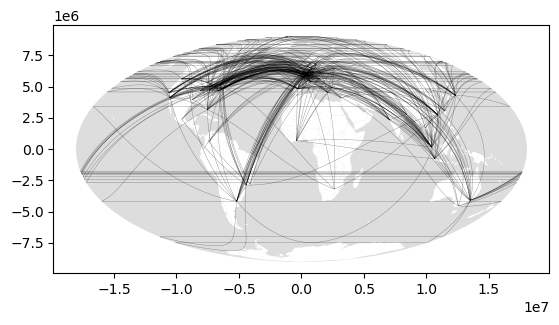

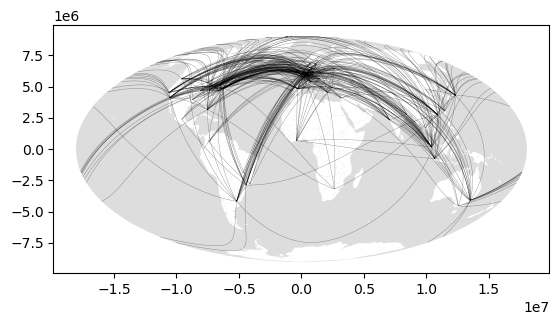

In [197]:
fig = pyplot.figure(figsize=(8, 4))
ax = globe_gdf.to_crs(moll).plot(fc = "#dddddd")
countries.to_crs(moll).plot(ax = ax, fc = "w", linewidth = 0)
geodesics_gdf.to_crs(moll).plot(ax = ax, color = "k", 
                                alpha = 0.5, linewidth = 0.25)

ax = globe_gdf.to_crs(moll).plot(fc = "#dddddd")
countries.to_crs(moll).plot(ax = ax, fc = "w", linewidth = 0)
geodesics_cut_gdf.to_crs(moll).plot(
  ax = ax, color = "k", alpha = 0.5, linewidth = 0.25)

## Orthographic not so fail maps

<Axes: >

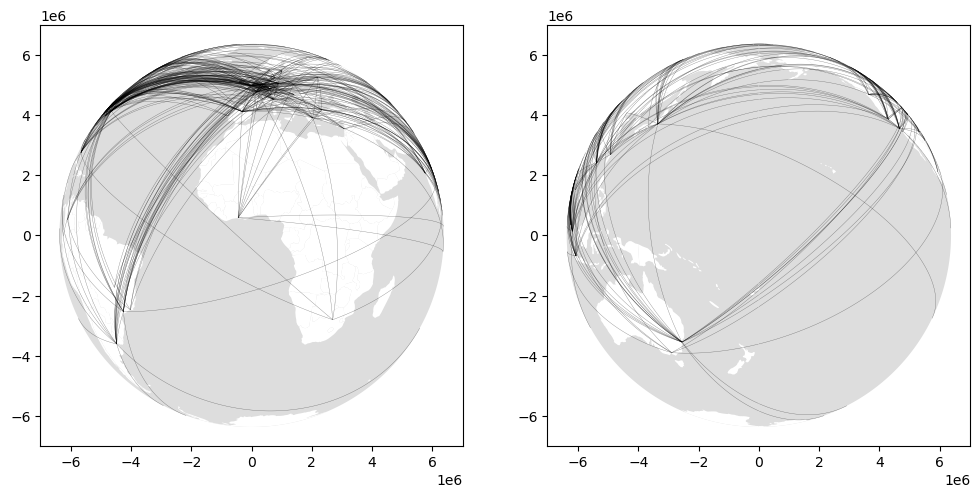

In [198]:
atlantic = "+proj=ortho +lon_0=0 +lat_0=0"
pacific = "+proj=ortho +lon_0=180 +lat_0=0"
half_globe = globe_gdf.copy()
half_globe.geometry = half_globe.geometry.scale(xfact = 0.5)

countries_a = gpd.read_file("atlantic.gpkg").to_crs(atlantic)
countries_p = gpd.read_file("pacific.gpkg").to_crs(pacific)

fig = pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(121)
half_globe.to_crs(atlantic).plot(ax = ax, fc = "#dddddd")
countries_a.to_crs(atlantic).plot(ax = ax, fc = "w", linewidth = 0)
geodesics_cut_gdf.to_crs(atlantic).plot(ax = ax, color = "k",
                                        alpha = 0.5, linewidth = 0.25)

ax = fig.add_subplot(122)
half_globe.to_crs(pacific).plot(ax = ax, fc = "#dddddd")
countries_p.to_crs(pacific).plot(ax = ax, fc = "w", linewidth = 0)
geodesics_cut_gdf.to_crs(pacific).plot(ax = ax, color = "k", 
                                       alpha = 0.5, linewidth = 0.25)